In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [3]:
def cost_function(bitstring, graph):
    '''
    Computes cost function.
    Inputs:
     bitstring (measured from circuit?)
     graph (networkx Graph)
    Returns cost value.
    '''
    edges = graph.edges()
    if (len(bitstring) != len(graph.nodes())):
        return np.nan

    cost = 0
    for edge in edges:
        edge1, edge2 = edge
        weight = graph[edge1][edge2]['weight']
        cost += weight * int(bitstring[edge1]) * (1 - int(bitstring[edge2]))\
              + weight * int(bitstring[edge2]) * (1 - int(bitstring[edge1]))

    return cost

In [4]:
# Generates butterfly graph to represent 5-qubit chip connectivity.
n_qubits = 5
qubit_nodes = np.arange(0, n_qubits)
edges = [(0, 1), (0, 2), (1, 2), (3, 2), (3, 4), (4, 2)]
edge_weight = 1
weighted_edges = [edge + (edge_weight,) for edge in edges]
graph = nx.Graph()
graph.add_nodes_from(qubit_nodes)
graph.add_weighted_edges_from(weighted_edges)

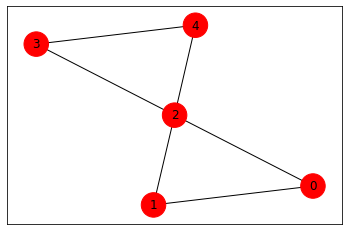

In [5]:
# Visualizes plot of graph.
colors = ['r' for node in graph.nodes()]
transparency = 1
default_axes = plt.axes(frameon=True)
position = nx.spring_layout(graph)
nx.draw_networkx(graph, node_color=colors, node_size=600, alpha=transparency,
                 ax=default_axes, pos=position)

In [6]:
# Maximize expectation for selected trial state, to be simulated.
step_size = 0.1
gamma = np.arange(0, np.pi, step_size)
beta = np.arange(0, np.pi, step_size)
gamma, beta = np.meshgrid(gamma, beta)    # generates coordinate grid of params

expectation = 3 - (np.sin(2 * beta)**2 * np.sin(2 * gamma)**2\
            - 0.5 * np.sin(4 * beta) * np.sin(4 * gamma))\
            * (1 + np.cos(4 * gamma)**2) 

In [8]:
# Compute maximum via grid search, with respect to parameters.
print("Maximizing expectation...")
max_expectation = np.amax(expectation)
results = np.where(expectation == max_expectation)
print("Expectation maximied.")
gamma_optimal, beta_optimal = [result[0] * step_size for result in results]

Maximizing expectation...
Expectation maximied.



---OPTIMAL PARAMETERS---
Maximal expectation value: 3.431
Optimal parameters, gamma = 1.900 and beta = 0.200


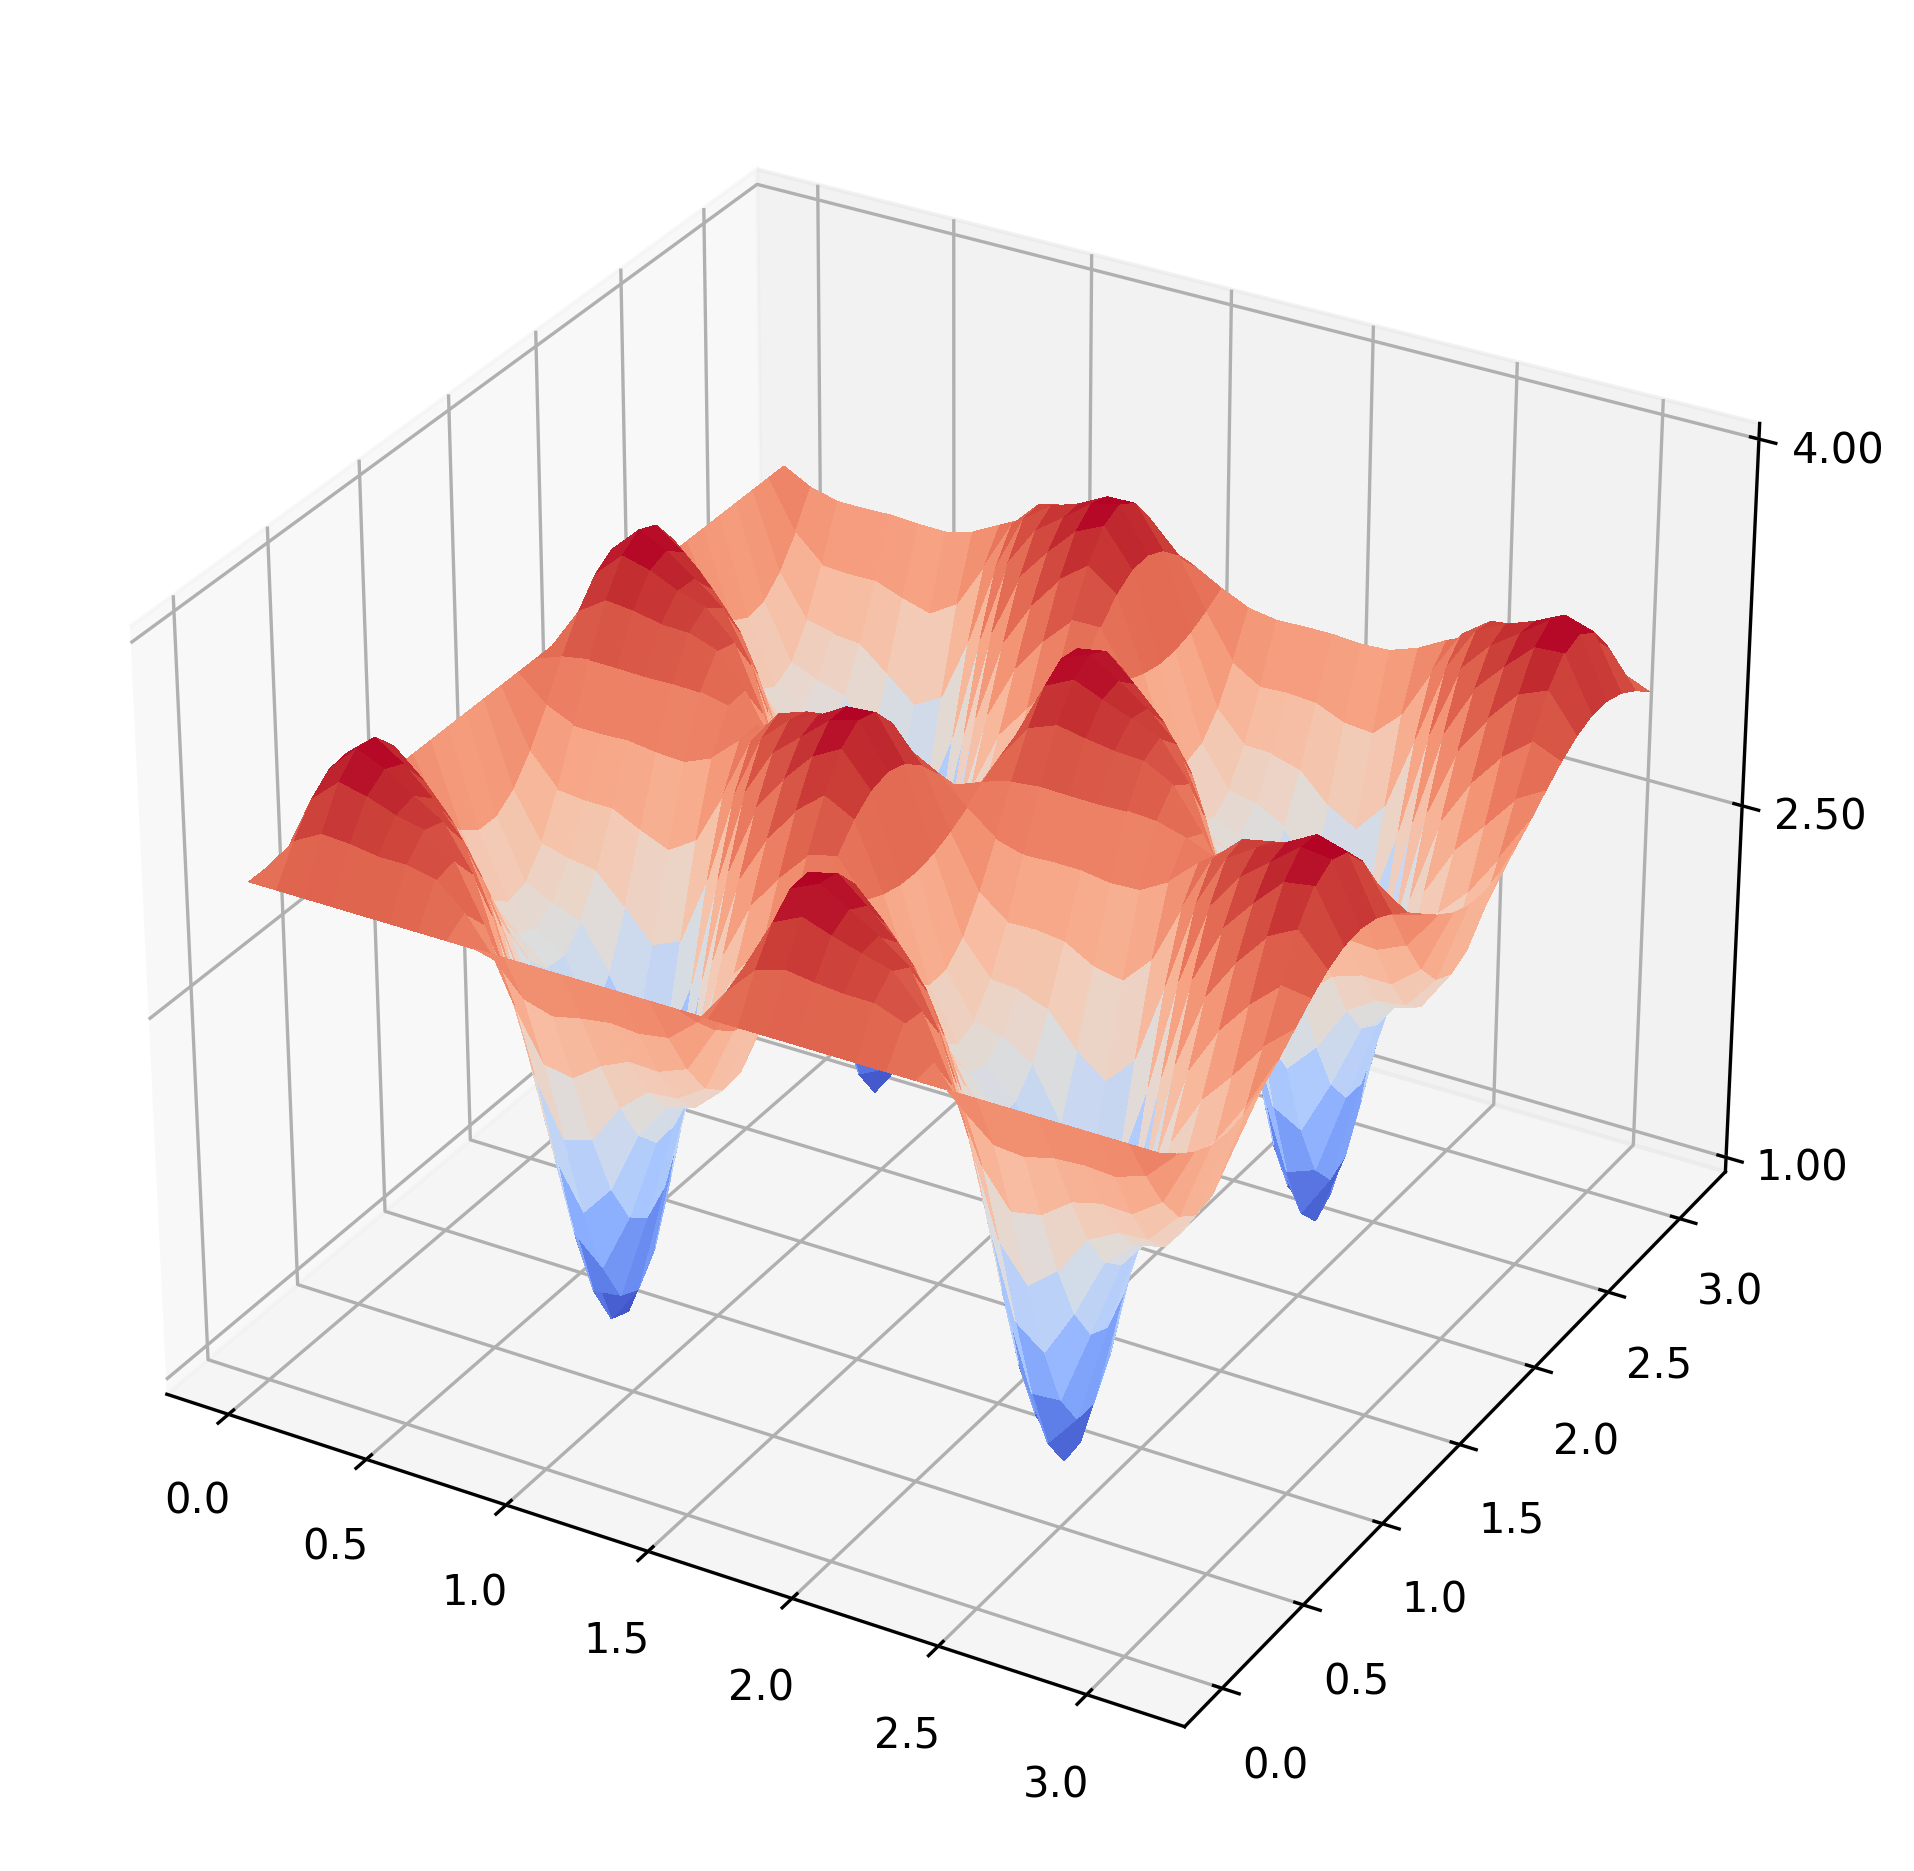

In [9]:
# Plots expectation value along z-axi vs. gamma and beta along x- and y- axes.
figure = plt.figure(figsize=(10, 8), dpi=300)
axis = figure.gca(projection='3d')
surface = axis.plot_surface(gamma, beta, expectation, cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)
axis.set_zlim(1, 4)
tick_locator = LinearLocator(3)
tick_formatter = FormatStrFormatter('%.02f')
axis.zaxis.set_major_locator(tick_locator)
axis.zaxis.set_major_formatter(tick_formatter)
#show_plot()
print("\n---OPTIMAL PARAMETERS---")
print("Maximal expectation value: %.3f" % max_expectation)
print("Optimal parameters, gamma = %.3f and beta = %.3f" % (gamma_optimal,
                                                            beta_optimal))

In [10]:
# Constructs quantum circuit to prepare trial state.
#  1. Apply 5 Hadamard gates to generate uniform superposition.
#  2. Apply 6 Ising gates with angle gamma along graph edges...
#  3. Apply singe-qubit X rotations (Pauli?)
#  4. Measure qubits in computational basis, i.e., perform Z-measurement and
#     record resulting bit-string. (Z = Pauli?)
qaoa_circuit = QuantumCircuit(n_qubits, n_qubits)
qaoa_circuit.h(qubit_nodes)    # try range(n_qubits)
qaoa_circuit.barrier()

for edge in edges:
    node1, node2 = edge
    qaoa_circuit.cp(-2 * gamma_optimal, node1, node2)
    qaoa_circuit.p(gamma_optimal, node1)
    qaoa_circuit.p(gamma_optimal, node2)
qaoa_circuit.barrier()

qaoa_circuit.rx(2 * beta_optimal, qubit_nodes)
qaoa_circuit.barrier()

qaoa_circuit.measure(qubit_nodes, qubit_nodes)

In [11]:
qaoa_circuit.draw()

┌───┐ ░           ┌────────┐          ┌────────┐                    »
q_0: ┤ H ├─░──■────────┤ P(1.9) ├─■────────┤ P(1.9) ├────────────────────»
     ├───┤ ░  │P(-3.8) ├────────┤ │        └────────┘          ┌────────┐»
q_1: ┤ H ├─░──■────────┤ P(1.9) ├─┼───────────────────■────────┤ P(1.9) ├»
     ├───┤ ░           └────────┘ │P(-3.8) ┌────────┐ │P(-3.8) ├────────┤»
q_2: ┤ H ├─░──────────────────────■────────┤ P(1.9) ├─■────────┤ P(1.9) ├»
     ├───┤ ░                               └────────┘          └────────┘»
q_3: ┤ H ├─░─────────────────────────────────────────────────────────────»
     ├───┤ ░                                                             »
q_4: ┤ H ├─░─────────────────────────────────────────────────────────────»
     └───┘ ░                                                             »
c: 5/════════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                  ░ »
«q_0: ─────────────────────────────────────────────────────────────░─»
«                                                                  ░ »
«q_1: ─────────────────────────────────────────────────────────────░─»
«               ┌────────┐                              ┌────────┐ ░ »
«q_2: ─■────────┤ P(1.9) ├─────────────────────■────────┤ P(1.9) ├─░─»
«      │P(-3.8) ├────────┤          ┌────────┐ │        └────────┘ ░ »
«q_3: ─■────────┤ P(1.9) ├─■────────┤ P(1.9) ├─┼───────────────────░─»
«               └────────┘ │P(-3.8) ├────────┤ │P(-3.8) ┌────────┐ ░ »
«q_4: ─────────────────────■────────┤ P(1.9) ├─■────────┤ P(1.9) ├─░─»
«                                   └────────┘          └────────┘ ░ »
«c: 5/═══════════════════════════════════════════════════════════════»
«                                                                    »
«     ┌─────────┐ ░ ┌─┐            
«q_0: ┤ Rx(0.4) ├─░─┤M├────────────
«     ├─────────┤ ░ └╥┘┌─┐         
«q_1: ┤ Rx(0.4) ├─░──╫─┤M├─────────
«     ├─────────┤ ░  ║ └╥┘┌─┐      
«q_2: ┤ Rx(0.4) ├─░──╫──╫─┤M├──────
«     ├─────────┤ ░  ║  ║ └╥┘┌─┐   
«q_3: ┤ Rx(0.4) ├─░──╫──╫──╫─┤M├───
«     ├─────────┤ ░  ║  ║  ║ └╥┘┌─┐
«q_4: ┤ Rx(0.4) ├─░──╫──╫──╫──╫─┤M├
«     └─────────┘ ░  ║  ║  ║  ║ └╥┘
«c: 5/═══════════════╩══╩══╩══╩══╩═
«                    0  1  2  3  4

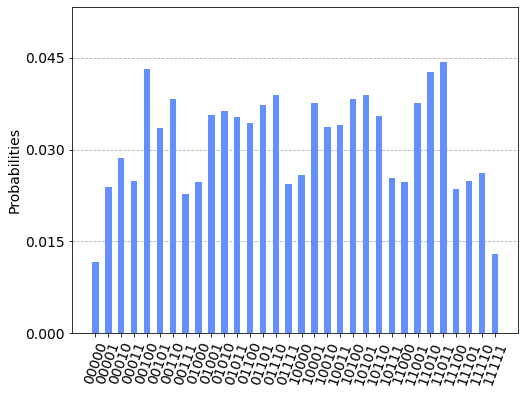

In [12]:
# Runs QAOA on local QASM simulator.
backend = Aer.get_backend("qasm_simulator")
shots = 10000
simulate = execute(qaoa_circuit, backend=backend, shots=shots)
qaoa_results = simulate.result()
counts = qaoa_results.get_counts()
plot_histogram(counts, figsize=(8, 6), bar_labels=False)

In [13]:
# Evaluate the simulation data.
# 1. Computes mean energy, compares with theoretical prediction.
# 2. Reports approximate solution, sampled bitstring with largest observed cost.
# 3. Plots energies to check concentration around predicted mean.
average_cost = 0
max_cost, approximate_bitstr = 0, ''
histogram = {}

for edge in range(len(edges) + 1):
    histogram[str(edge)] = histogram.get(str(edge), 0)

for bitstr in counts:
    cost = cost_function(bitstr, graph) 
    average_cost += counts[bitstr] * cost
    histogram[str(round(cost))] = histogram.get(str(round(cost)), 0)\
                                + counts[bitstr]
    if max_cost < cost:
        max_cost = cost
        approximate_bitstr = bitstr


sampled_mean = average_cost / shots

In [14]:
sampled_mean

3.3022